After the EDA step, we have a first look at the distribution of data fields. The next thing to do is to clean the data by handling outliers or missing values. Additionally, due to the nature of data collection, the same values ​​may be stored in the database in different formats or have spelling errors in the category data. Numerical and categorical data require different treatments.

# Handling outliers

What are outliers in the data?
- With numbers, outlier data can be an unrealistic value such as a negative age, or a value that is very different from the rest of the values ​​in that field. In category form, outlier data can be an unrealistic value such as an item that is out of the realm of possibility such as a place that is not on the map. Values ​​with an extremely low frequency in a column of data are also likely to be an outlier.

## Digital data

Arithmetic transformations are relatively sensitive to outliers (too large or too small). In particular, if we want to build a feature based on the mean of a column, outliers can change the mean significantly. For example, village A has 100 houses, of which 99 houses have an income of 1 million/month. The remaining house belongs to a rich man with an income of 3 billion/month. Thus, the village's "average income" is nearly 33 million/month. Another village B has every house with an income of about 5-10 million/month. If a company wants to open a grocery store based on the per capita income of each village, then obviously village A is rated higher even though in reality village B has a higher standard of living.

Outliers also greatly affect the quality of machine learning models. Consider the simple example below.

There is a data table with height stored in the <code>height</code> column and <code>weight</code> stored in weight. Suppose column <code>height_2</code> is a version of height with the only difference being that the first person's height is 110cm instead of 147cm. The <code>weight_2</code> column is only different from the weight column in the second line with a weight of 90kg instead of 50 kg. The first line in <code>height_2</code> and the second line in <code>weight_2</code> can be considered outliers. These values ​​may be due to recording errors or may actually be real data.

In [2]:
import pandas as pd
df_example = pd.DataFrame(
    data={
        "height": [147, 150, 153, 158, 163, 165, 168, 170, 173, 175, 178, 180, 183],
        "weight": [49, 50, 51, 54, 58, 59, 60, 62, 63, 64, 66, 67, 68],
        "height_2": [110, 150, 153, 158, 163, 165, 168, 170, 173, 175, 178, 180, 183],
        "weight_2": [49, 90, 51, 54, 58, 59, 60, 62, 63, 64, 66, 67, 68],
    }
)
df_example

,height,weight,height_2,weight_2
0,147,49,110,49
1,150,50,150,90
2,153,51,153,51
3,158,54,158,54
4,163,58,163,58
5,165,59,165,59
6,168,60,168,60
7,170,62,170,62
8,173,63,173,63
9,175,64,175,64


Suppose we need to use this data set to build a model to predict weight by height. We can see that weight is often proportional to height, so the linear regression model will be suitable for this job. The figure below shows the results learned by the linear regression model in three cases:

- Case 1 (left): use data in height column as input, in weight column as label.

- TH2 (middle): uses data in column <code>height_2</code> as input, in column weight as label.

- Case 3 (right): use data in height column as input, in <code>weight_2</code> column as label.

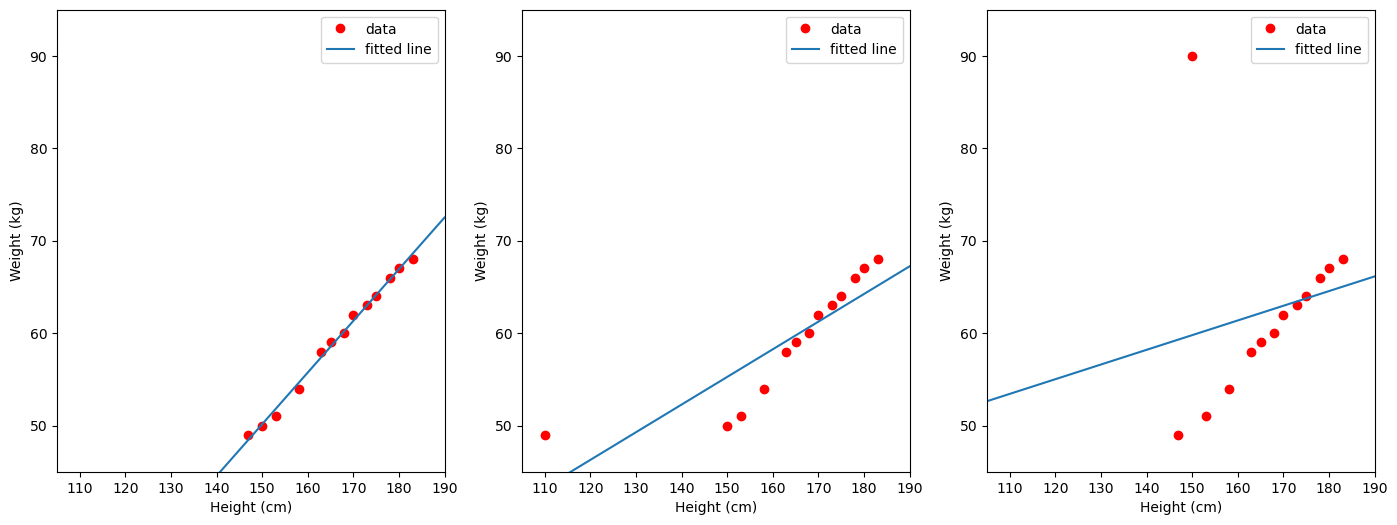

In [3]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression


def fit_linear_regression_and_visualize(
    df: pd.DataFrame, input_col: str, label_col: str
):
    # fit the model by Linear Regression
    lin_reg = LinearRegression(fit_intercept=True)
    lin_reg.fit(df[[input_col]], df[label_col])
    w1 = lin_reg.coef_
    w0 = lin_reg.intercept_

    # visualize
    plt.plot(df[input_col], df[label_col], "ro", label="data")
    plt.axis([105, 190, 45, 75])
    plt.xlabel("Height (cm)")
    plt.ylabel("Weight (kg)")
    plt.ylim(45, 95)
    plt.plot([105, 190], [w1 * 105 + w0, w1 * 190 + w0], label="fitted line")
    plt.legend()


plt.figure(figsize=(17, 6))
plt.subplot(1, 3, 1)
fit_linear_regression_and_visualize(df_example, input_col="height", label_col="weight")

plt.subplot(1, 3, 2)
fit_linear_regression_and_visualize(df_example, input_col="height_2", label_col="weight")

plt.subplot(1, 3, 3)
fit_linear_regression_and_visualize(df_example, input_col="height", label_col="weight_2")

The red points represent data points with the horizontal axis being weight and the vertical axis being height. The blue line is the line that the linear regression model learned. We can see that the blue line in the left figure fits the data quite well, while the two straight lines in the other two cases deviate quite a bit even though there is only one outlier data point in each case.

Thus, with this very simple data, outlier data whether in the model input or labels give bad results.

## Identify and handle outliers

There are two groups of outliers:
- The values ​​are not within the specified range of the data. For example, age, income or distance cannot be negative numbers.
- The values ​​are likely to occur but the probability is very low. For example, 120 years old, income 1 million $/month. These values ​​are possible but actually rare.

In general, we can always delete columns or rows with outlier data. If we delete the column, we may waste a lot of non-outlier values ​​in other rows. If we delete rows, we need to pay attention to how to handle new data. That is, what if a new data point also has an outlier? We cannot leave the prediction at that point, but there must be a way to transform this outlier data to more reasonable values.

With data in the first group, we can replace it with nan and treat it as a missing value. Sometimes missing values ​​are encoded with a special value that is not in the range of possible values ​​of the data.

With data in the second group, people often use the upper or lower blocking method (clipping or capping). That is, when a value is too large or too small, we bring it to the largest/smallest value that is considered normal points. For example, with an age value of 120, we can set it to 70 and assume that this data point has the general characteristics of “elderly people”. One point worth noting is that choosing the largest/smallest value also depends on the data. If the data only includes elderly people aged 65 and older, then obviously blocking above by 70 is not reasonable because 70 is still too young in this data set.

So how to choose those largest and smallest values?
- The most common way is to use Box plot. Box plot not only helps determine whether the data has outliers, but also helps find the largest and smallest threshold to use as a cutting point.

## Box plot

In [5]:
housing_path = "https://media.githubusercontent.com/media/tiepvupsu/tabml_data/master/california_housing/"
df_housing = pd.read_csv(housing_path + "housing.csv")

<Axes: >

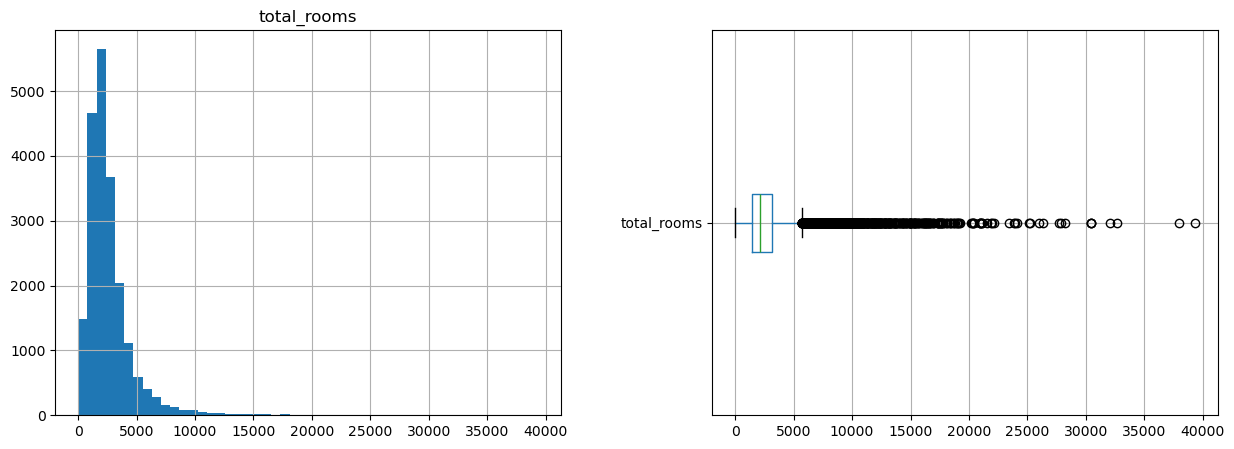

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
df_housing[["total_rooms"]].hist(bins=50, ax=axes[0]);
df_housing[["total_rooms"]].boxplot(ax=axes[1], vert=False)

From the histogram we see that the data is skewed to the right (there are outliers that skew much to the right, or the "tail" of the histogram is to the right). From the boxplot we see that there are quite a few points that are considered outliers. Outliers can be handled by clipping the minimum and maximum values ​​of the Box plot. This processor can be implemented as the sklearn API as follows:

In [7]:
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin


def find_boxplot_boundaries(
    col: pd.Series, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    """Findx minimum and maximum in boxplot.

    Args:
        col: a pandas serires of input.
        whisker_coeff: whisker coefficient in box plot
    """
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper


class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

Applying it again to the data of the "total_rooms" column, we have a new histogram and boxplot as follows:

<Axes: >

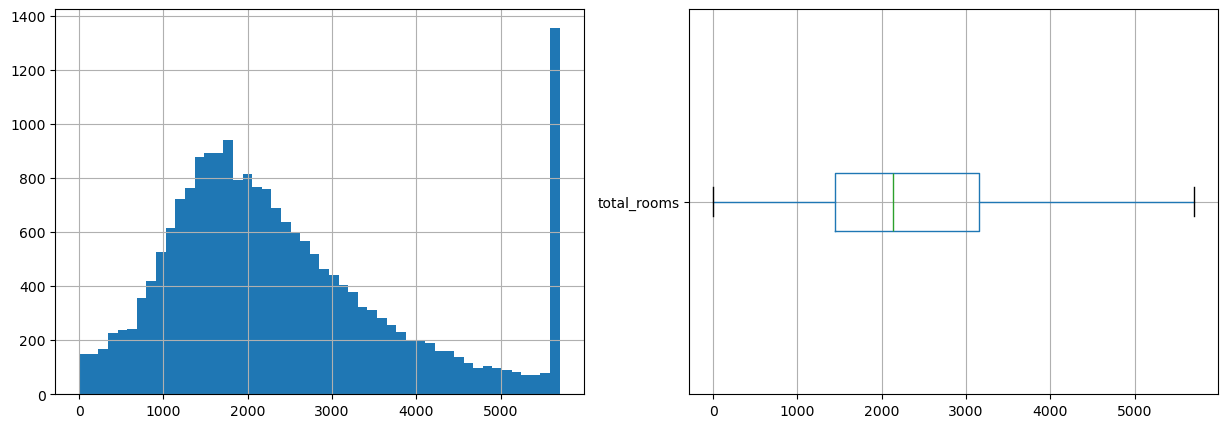

In [8]:
clipped_total_rooms = BoxplotOutlierClipper().fit_transform(df_housing["total_rooms"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
clipped_total_rooms.hist(bins=50, ax=axes[0])
clipped_total_rooms.to_frame().boxplot(ax=axes[1], vert=False)

After clipping the data according to the minimum and maximum of the box plot, we see that the data is less skewed. The box plot also shows that there are no more outlier data points.

Once the data clips are equal to the maximum and minimum of the boxplot, the new data is always without outliers. This is achieved because the clip transform does not change the quartiles of the data. The “valid” range of the boxplot before and after the clip does not change.

Next, let's try to apply this method to the first example.

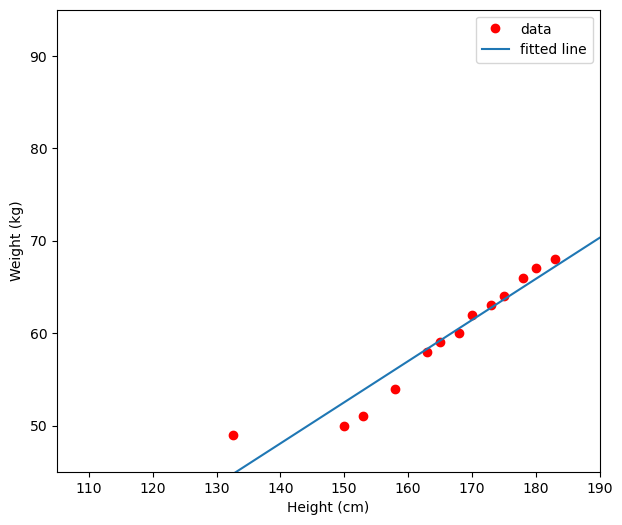

In [9]:
df_example["height_2_clipped"] = BoxplotOutlierClipper().fit_transform(
    df_example["height_2"]
)

plt.figure(figsize=(7, 6))
fit_linear_regression_and_visualize(
    df_example, input_col="height_2_clipped", label_col="weight"
)

Thus, after processing outlier data points, the learned model (blue line) gives more reasonable results.

## Z score

If you believe that the values ​​in a data field follow a normal distribution, you can apply the rule $3\sigma$ for normal distribution.

In a normal distribution, say $\mu$ is the mean and $\sigma$ is the standard deviation. Then rule $3\sigma$ for normal distribution states that:
- $68$% of the data points are within the range $[\mu - \sigma, \mu + \sigma]$.
- $95$% of the data points are within the range $[\mu - 2\sigma, \mu + 2\sigma]$.
- $99.7$% of the data points are within the range $[\mu - 3\sigma, \mu + 3\sigma]$.

With a single data point $x$, the Z score is calculated as follows:

$$ Z = \frac{x - \mu}{\sigma} $$

All the point have z score in the range $[-3, 3]$ are considered normal points. Points with z score outside this range are considered outliers. Transforming the math a bit, this is equivalent to the points falling outside the segment $[\mu - 3\sigma, \mu + 3\sigma]$.

In [10]:
class ZscoreOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, z_threshold: float = 3):
        self.z_threshold = z_threshold
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        mean = X.mean()
        std = X.std()
        self.lower = mean - self.z_threshold * std
        self.upper = mean + self.z_threshold * std
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

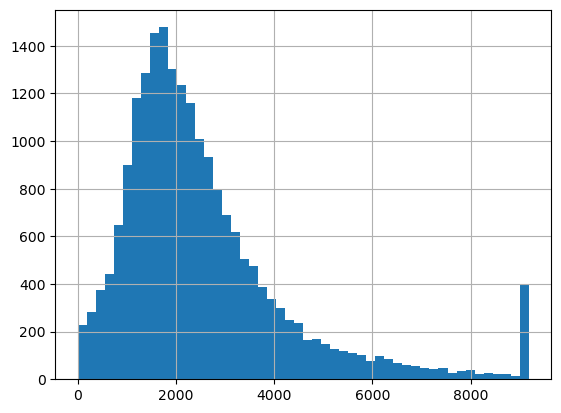

In [11]:
clipped_total_rooms2 = ZscoreOutlierClipper().fit_transform(df_housing["total_rooms"])
clipped_total_rooms2.hist(bins=50)

<Axes: >

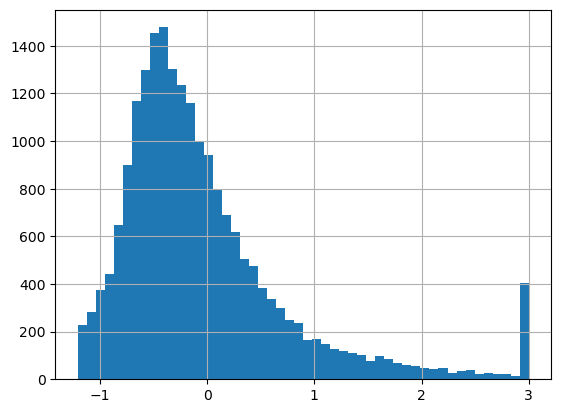

In [12]:
# Equivalent to
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
z_scores = scaler.fit_transform(df_housing[["total_rooms"]])
clipped_total_rooms3 = pd.Series(z_scores.squeeze()).clip(-3, 3)
clipped_total_rooms3.hist(bins=50)

We have a few comments below:
- Compared to box plot, z score in this case returns a wider range of values. Values ​​greater than about 9000 are considered outliers while the upper bound number of the box plot is approximately 6000.

- This z score method is sensitive to extreme outliers. A large outlier shifts the expectation to the right and the standard deviation becomes larger. This leads to a different definition of the upper and lower bound values. In contrast, with a box plot, having an extremely large outlier does not change the quartiles, so the upper and lower bounds are not affected.

- After applying the z score clip method and calculating the z score according to the new data, we will again be able to find new outliers as follows:

<Axes: >

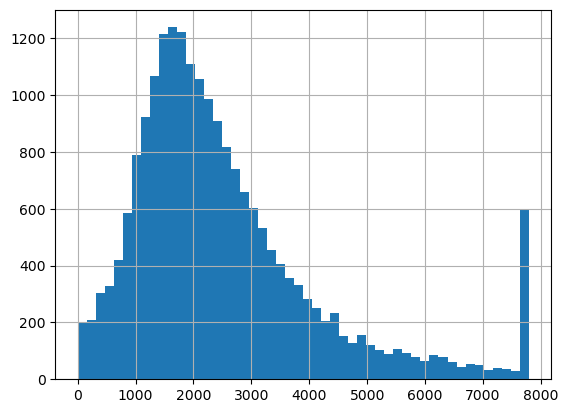

In [13]:
clipped_total_rooms3 = ZscoreOutlierClipper().fit_transform(clipped_total_rooms2)
clipped_total_rooms3.hist(bins=50)

At this time, the upper bound has moved to the left of 8000. Thus, the z score method is quite sensitive to large noise and is not as stable as the box plot method.

## Category data

Unlike the case of numeric data, exceptional data in category information fields is more difficult to detect. Partly because of the difficulty of drawing a histogram, especially when there are many different category values, partly outliers of this type require expert knowledge of valid values.

With category data, outliers can occur in one of the following cases:

- Due to differences in data entry. For example, a part of the data obtained is in uppercase, another small part is in lowercase, like <code>VIETNAM</code> and <code>Vietnam</code>. Another example is a category having many different names, such as “City” and “City”. In this case, we need to normalize the values ​​to the same form to eliminate outliers.

- Due to spelling errors, some samples have different values ​​from the rest. To handle misspelled data, we can draw a histogram showing the frequency of each value in the entire data. Typically, spelling errors are in low-frequency categories. These errors need to be corrected before going to the next step.

- Some categories appear too infrequently in the data. These values ​​may or may not require treatment, the answer can be obtained through experimentation. Items with low frequency easily cause the model to overfit. However, there are cases where these values ​​are closely related to the label column and should not be discarded. If it needs to be handled, a common way is to group low-frequency items into a new category, which can be named “rare”.

- The category does not appear in the training set. There are many cases where a value in the “Serving” step has never appeared in the old database. This often happens with recommender systems when users and products change constantly. In this case, a common way is to create a new category called "unknown" when building training data. Whenever there is a new value, we can put it in this category.

A method that has been used a lot recently for the last two cases is Hashing, which we will learn later.

Below is the histogram of the <code>ocean_proximity</code> column of the California Housing dataset. This is a category data field with five different values. Here, the <code>ISLAND</code> category has a very low frequency but we cannot ignore it:

<Axes: >

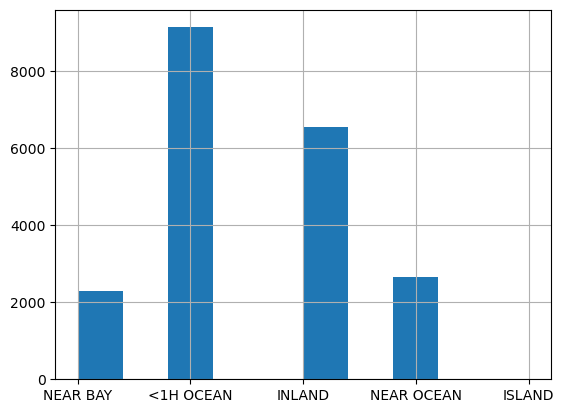

In [14]:
df_housing["ocean_proximity"].hist()

To decide whether we should include <code>ISLAND</code> in one of the remaining categories, we can draw a histogram according to the label column, here <code>medium_house_value</code> with different values ​​of <code>ocean_proximity</code>.

Text(0.5, 1.0, 'NOT ISLAND')

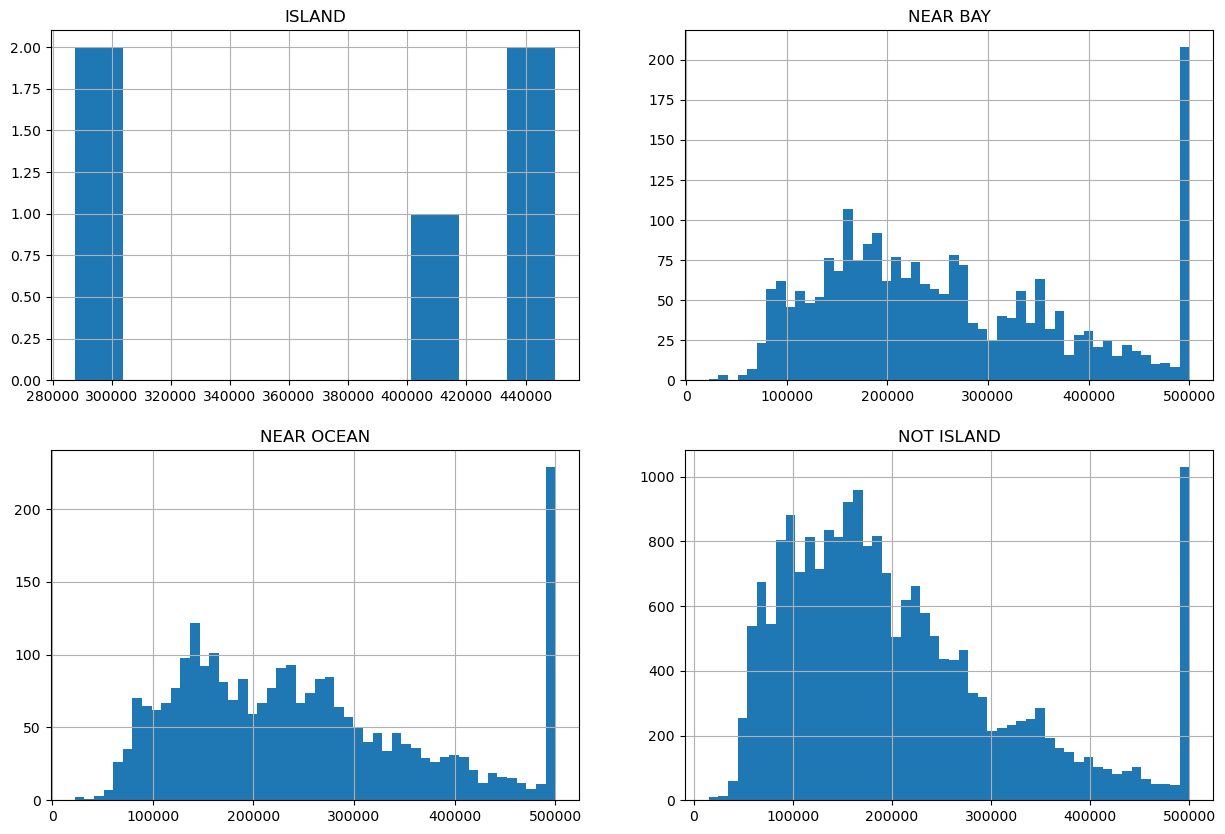

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10));
df_housing[df_housing["ocean_proximity"] == "ISLAND"]["median_house_value"].hist(ax=axes[0][0])
axes[0][0].set_title("ISLAND")
df_housing[df_housing["ocean_proximity"] == "NEAR BAY"]["median_house_value"].hist(bins=50, ax=axes[0][1]);
axes[0][1].set_title("NEAR BAY")
df_housing[df_housing["ocean_proximity"] == "NEAR OCEAN"]["median_house_value"].hist(bins=50, ax=axes[1][0]);
axes[1][0].set_title("NEAR OCEAN")
df_housing[df_housing["ocean_proximity"] != "ISLAND"]["median_house_value"].hist(bins=50, ax=axes[1][1]);
axes[1][1].set_title("NOT ISLAND")

We can see that houses in <code>ISLAND</code> have quite high values, from about $300k or more, while other areas have prices concentrated in lower segments. It appears that <code>ISLAND</code> is a good indicator of home valuations and should be treated as a separate category. However, you can also try to combine <code>ISLAND</code> with another category and give it a try.

In Machine Learning, there is no absolute best method. Determining which idea is better is mostly based on many experiments. Given the constraints of time and resources, you should start with ideas that you feel will yield better results than before.

If we want to include <code>ISLAND</code> in another value, such as <code>NEAR BAY</code>, we can do as follows:

C:\Users\nguye\AppData\Local\Temp\ipykernel_20180\4223307554.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NEAR BAY' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_housing[df_housing["ocean_proximity"] == "ISLAND"] = "NEAR BAY"
C:\Users\nguye\AppData\Local\Temp\ipykernel_20180\4223307554.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NEAR BAY' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_housing[df_housing["ocean_proximity"] == "ISLAND"] = "NEAR BAY"
C:\Users\nguye\AppData\Local\Temp\ipykernel_20180\4223307554.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NEAR BAY' has dtype incompatible with float64, please explicitly cast to a c

<Axes: >

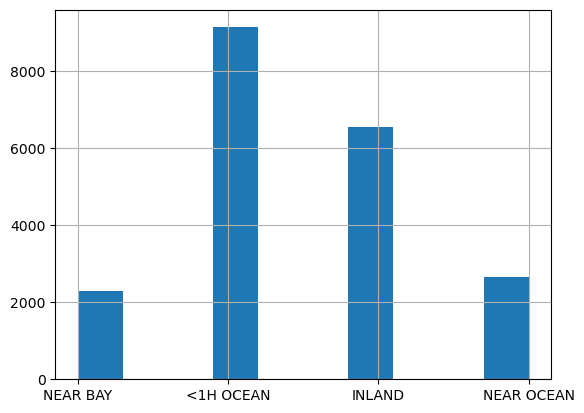

In [16]:
df_housing[df_housing["ocean_proximity"] == "ISLAND"] = "NEAR BAY"
df_housing["ocean_proximity"].hist()

After merging, we see that the "ocean_proximity" column only has four categories left

# Handling missing data

With table data, missing information fields (single values) often happens. This comes from the data collection process. Users may not actually have that information or they may not want to disclose it for personal privacy reasons.

So, what do we need to do with missing data?

A simple way is to remove the entire information column with missing data from the model building process. This method is simple but has certain limitations. If there are too many columns with missing data and we remove these columns, there will be no information left for building the model.

The second way is to remove the missing row from the training set. This also has the same limitation as above, so each row loses a bit of data. The second limitation is that when we encounter a new data point that the model needs to predict, we cannot simply remove that data point and still have to predict a certain value.

There is a general rule that if a column has too much missing data, we can remove that column. Finding what is too much depends on the nature of the data and the experience of the engineers. If the data has too little information and removing it can reduce model quality.

If you want to keep a column with missing information, there are two main directions.

The first is to create a new column is_nan that carries information about whether data is missing or not. Sometimes missing information is also valuable information. A person who does not declare their phone number may be because they do not have a phone. A person who hides their device's IP address shows that they value privacy and have certain computer skills. Thus, the lack of information is also information that can be exploited.

The second way we can solve the problem of missing data is to "fill" the missing values ​​with a certain value and then use that value to build the model.

## Numeric data

With numeric data, the two most common and simple ways are to fill missing values ​​with the average or median of non-missing values. These are safe choices because the average or median are values ​​that are highly likely to occur. A point worth noting is that taking this average or median should be considered based on data before or after processing outliers.

The scikit-learn library with the <code>sklearn.impute.SimpleImputer</code> class is often used for this task. Take for example the <code>Age</code> column in the Titanic data. In this data set, the "train.csv" set has $891 − 714 = 177$ missing points, the "test.csv" set has $418 − 332 = 86$ missing points.

In [1]:
import pandas as pd

titanic_path = "https://media.githubusercontent.com/media/tiepvupsu/tabml_data/master/titanic/"

df_train = pd.read_csv(titanic_path + "train.csv")
df_test = pd.read_csv(titanic_path + "test.csv")
df_train[["Age"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     714 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


In [2]:
df_test[["Age"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     332 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


Another point worth noting is that the calculation of the value to fill is based only on the training data, in this case the "train.csv" file. When filling in missing values ​​in the "test.csv" file, we need to use the results obtained in the "train.csv" file. Below is a specific example using "sklearn.impute.SimpleImputer" and filling in 'median'.

In [3]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
imputer.fit(df_train[["Age"]])
df_train[["ImputedAge"]] = imputer.transform(df_train[["Age"]])
df_test[["ImputedAge"]] = imputer.transform(df_test[["Age"]])

df_train[["Age", "ImputedAge"]].tail(3)

,Age,ImputedAge
888,NaN,28.0
889,26.0,26.0
890,32.0,32.0


In [4]:
df_test[["Age", "ImputedAge"]].tail(3)

,Age,ImputedAge
415,38.5,38.5
416,NaN,28.0
417,NaN,28.0


The code above calculates the median value (strategy='median') based on the non-missing points in the training set and then fills both sets. We see that the NaN values ​​in the Age column have been filled with a value close to 28.0
 in the ImputedAge column. You can also try other strategies to see which brings the best results. Remember that there is no one correct way to fill in values ​​for all types of data, you need to understand the data to come up with the option that you think has the best results.

If you have more time, you can fill in the values ​​more meticulously. For example, fill in different missing age values ​​for each gender category.

## Category data

With category data, because we cannot calculate the average value, the common way is to fill in the value that appears most often (strategy = 'mode') or consider the missing event itself as a special value (strategy = 'constant') with a special value passed through the "fill_value" variable (See more at "sklearn.impute.SimpleImputer").